In [1]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)

trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist , batch_size=4,
                                          shuffle=True, num_workers=2)
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=4,
                                         shuffle=False, num_workers=2)

In [5]:
def show_images(dataset, title, num_images=5):
    plt.figure(figsize=(10, 2))
    plt.suptitle(title, fontsize=10)

    for i in range(num_images):
        image, label = dataset[i]  
        image = image.squeeze().numpy() 
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}", fontsize=6)
        plt.axis('off')
    
    plt.show()

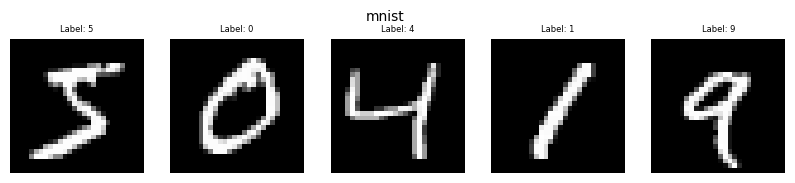

In [6]:
show_images(trainset_mnist, "mnist")

In [7]:
import torch.nn as nn
import torch.nn.functional as F 

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        
        self.fc1 = nn.Linear(32 * 1 * 1, 256)  
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, 32 * 1 * 1)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
from tqdm import tqdm_notebook

In [10]:
net = ConvNet().to(device)

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [14]:
def train_model(model=net, trainloader=trainloader_mnist, testloader=testloader_mnist, loss_fn=loss_fn, 
                learning_rate = learning_rate, optimizer=optimizer, epoch=5):
    acc = []
    epochs = list(range(1, epoch + 1))

    losses = [0] * epoch
    for epoch in tqdm_notebook(range(epoch)):
        running_loss = 0.0
        for i, batch in enumerate(tqdm_notebook(trainloader)):
            X_batch, y_batch = batch

            optimizer.zero_grad()

            # forward + backward + optimize
            y_pred = model(X_batch.to(device))
            loss = loss_fn(y_pred, y_batch.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            losses[epoch] += loss.item() / 2000    

        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                y_pred = model(images.to(device))


                _, predicted = torch.max(y_pred, 1)

                c = (predicted.cpu().detach() == labels)
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        avg_accuracy = 0
        for i in range(10):
            avg_accuracy += class_correct[i] / class_total[i] 

        acc.append(avg_accuracy / 10)  
        
    return losses, acc, epochs

In [15]:
loss, acc, epochs = train_model()


/tmp/ipykernel_7664/2341957506.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epoch)):


  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_7664/2341957506.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.261
[1,  4000] loss: 0.466
[1,  6000] loss: 0.312
[1,  8000] loss: 0.266
[1, 10000] loss: 0.221
[1, 12000] loss: 0.184
[1, 14000] loss: 0.170


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.147
[2,  4000] loss: 0.141
[2,  6000] loss: 0.134
[2,  8000] loss: 0.125
[2, 10000] loss: 0.116
[2, 12000] loss: 0.111
[2, 14000] loss: 0.112


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.092
[3,  4000] loss: 0.094
[3,  6000] loss: 0.088
[3,  8000] loss: 0.088
[3, 10000] loss: 0.095
[3, 12000] loss: 0.087
[3, 14000] loss: 0.083


  0%|          | 0/15000 [00:00<?, ?it/s]

[4,  2000] loss: 0.076
[4,  4000] loss: 0.071
[4,  6000] loss: 0.074
[4,  8000] loss: 0.073
[4, 10000] loss: 0.065
[4, 12000] loss: 0.072
[4, 14000] loss: 0.066


  0%|          | 0/15000 [00:00<?, ?it/s]

[5,  2000] loss: 0.062
[5,  4000] loss: 0.060
[5,  6000] loss: 0.063
[5,  8000] loss: 0.054
[5, 10000] loss: 0.054
[5, 12000] loss: 0.053
[5, 14000] loss: 0.063


In [16]:
def make_plot(epochs, losses=loss, acc=acc, title_x='epochs', title_y_loss='loss', title_y_acc='accuracy'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))  # 1 строка, 2 столбца
    
    ax1.plot(epochs, losses)
    ax1.set_xticks(np.arange(min(epochs), max(epochs) + 1, 1.0))
    ax1.set_xlabel(title_x)
    ax1.set_ylabel(title_y_loss)
    ax1.set_title('Training Loss')
    
    ax2.plot(epochs, acc)
    ax2.set_xticks(np.arange(min(epochs), max(epochs) + 1, 1.0))
    ax2.set_xlabel(title_x)
    ax2.set_ylabel(title_y_acc)
    ax2.set_title('Accuracy')
    
    plt.tight_layout() 
    plt.show()

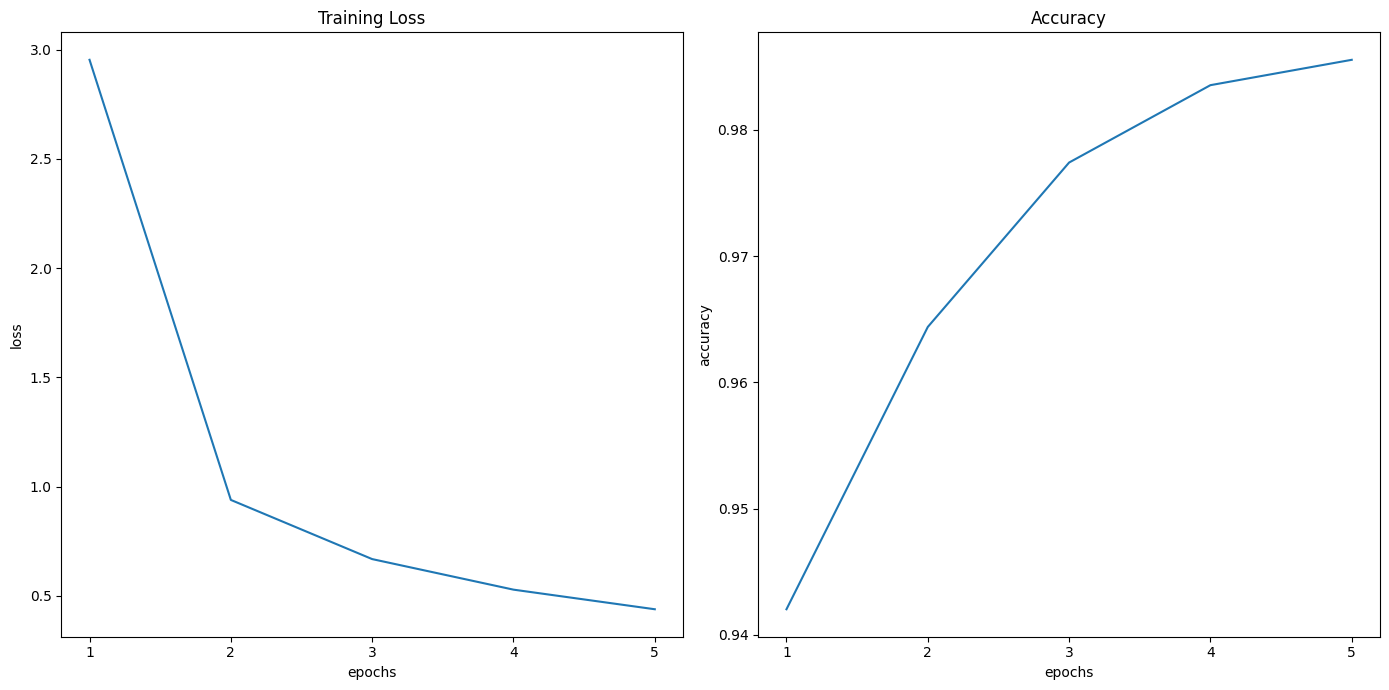

In [17]:
make_plot(epochs)

In [18]:
from torchvision.datasets import SVHN

In [19]:
transform_svhn = transforms.Compose([
    transforms.Grayscale(),       
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),
])


trainset_svhn = SVHN(root='./data', split='train', 
                     download=True, transform=transform_svhn)
testset_svhn = SVHN(root='./data', split='test', 
                    download=True, transform=transform_svhn)

trainloader_svhn = torch.utils.data.DataLoader(trainset_svhn, batch_size=4,
                                             shuffle=True, num_workers=2)
testloader_svhn = torch.utils.data.DataLoader(testset_svhn, batch_size=4,
                                            shuffle=False, num_workers=2)

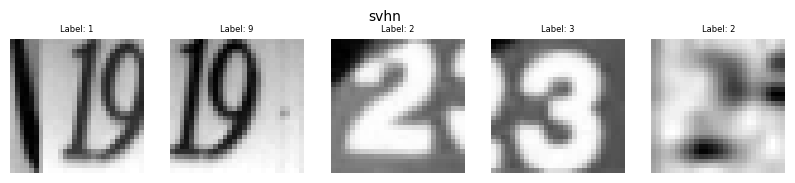

In [20]:
show_images(trainset_svhn, "svhn")

In [21]:
torch.save(net.state_dict(), 'convnet_params.pth') 

In [22]:
class DualConvNet(ConvNet):
    def __init__(self, original_model=None):
        super().__init__()
        
        if original_model is not None:
            self.load_state_dict(original_model.state_dict(), strict=False)
        
        self.new_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def freeze(self):
        for name, param in self.named_parameters():
                if "new_head" not in name:  
                    param.requires_grad = False
    def unfreeze(self):
        for name, param in self.named_parameters():
                param.requires_grad = True

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 1 * 1)
        x = F.relu(self.fc1(x))
        features = F.relu(self.fc2(x))
          
        out = self.new_head(features)
        return out

In [23]:
model_dual = DualConvNet(net).cuda()

In [24]:
model_dual.freeze()

#check freeze mode 
for name, param in model_dual.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

conv1.weight: requires_grad = False
conv1.bias: requires_grad = False
conv2.weight: requires_grad = False
conv2.bias: requires_grad = False
conv3.weight: requires_grad = False
conv3.bias: requires_grad = False
fc1.weight: requires_grad = False
fc1.bias: requires_grad = False
fc2.weight: requires_grad = False
fc2.bias: requires_grad = False
fc3.weight: requires_grad = False
fc3.bias: requires_grad = False
new_head.0.weight: requires_grad = True
new_head.0.bias: requires_grad = True
new_head.2.weight: requires_grad = True
new_head.2.bias: requires_grad = True


In [25]:
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model_dual.parameters(), lr=learning_rate)

In [26]:
loss, acc, epochs = train_model(model=model_dual, trainloader=trainloader_svhn, 
                                testloader=testloader_svhn, loss_fn=loss_fn, 
                learning_rate = learning_rate, optimizer=optimizer, epoch=5)

/tmp/ipykernel_7664/2341957506.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epoch)):


  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_7664/2341957506.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/18315 [00:00<?, ?it/s]

[1,  2000] loss: 2.153
[1,  4000] loss: 1.977
[1,  6000] loss: 1.894
[1,  8000] loss: 1.827
[1, 10000] loss: 1.797
[1, 12000] loss: 1.798
[1, 14000] loss: 1.771
[1, 16000] loss: 1.758
[1, 18000] loss: 1.762


  0%|          | 0/18315 [00:00<?, ?it/s]

[2,  2000] loss: 1.741
[2,  4000] loss: 1.750
[2,  6000] loss: 1.737
[2,  8000] loss: 1.700
[2, 10000] loss: 1.703
[2, 12000] loss: 1.713
[2, 14000] loss: 1.702
[2, 16000] loss: 1.697
[2, 18000] loss: 1.690


  0%|          | 0/18315 [00:00<?, ?it/s]

[3,  2000] loss: 1.684
[3,  4000] loss: 1.681
[3,  6000] loss: 1.678
[3,  8000] loss: 1.661
[3, 10000] loss: 1.671
[3, 12000] loss: 1.661
[3, 14000] loss: 1.656
[3, 16000] loss: 1.653
[3, 18000] loss: 1.656


  0%|          | 0/18315 [00:00<?, ?it/s]

[4,  2000] loss: 1.630
[4,  4000] loss: 1.642
[4,  6000] loss: 1.637
[4,  8000] loss: 1.637
[4, 10000] loss: 1.621
[4, 12000] loss: 1.631
[4, 14000] loss: 1.629
[4, 16000] loss: 1.637
[4, 18000] loss: 1.645


  0%|          | 0/18315 [00:00<?, ?it/s]

[5,  2000] loss: 1.618
[5,  4000] loss: 1.603
[5,  6000] loss: 1.624
[5,  8000] loss: 1.607
[5, 10000] loss: 1.606
[5, 12000] loss: 1.629
[5, 14000] loss: 1.591
[5, 16000] loss: 1.606
[5, 18000] loss: 1.601


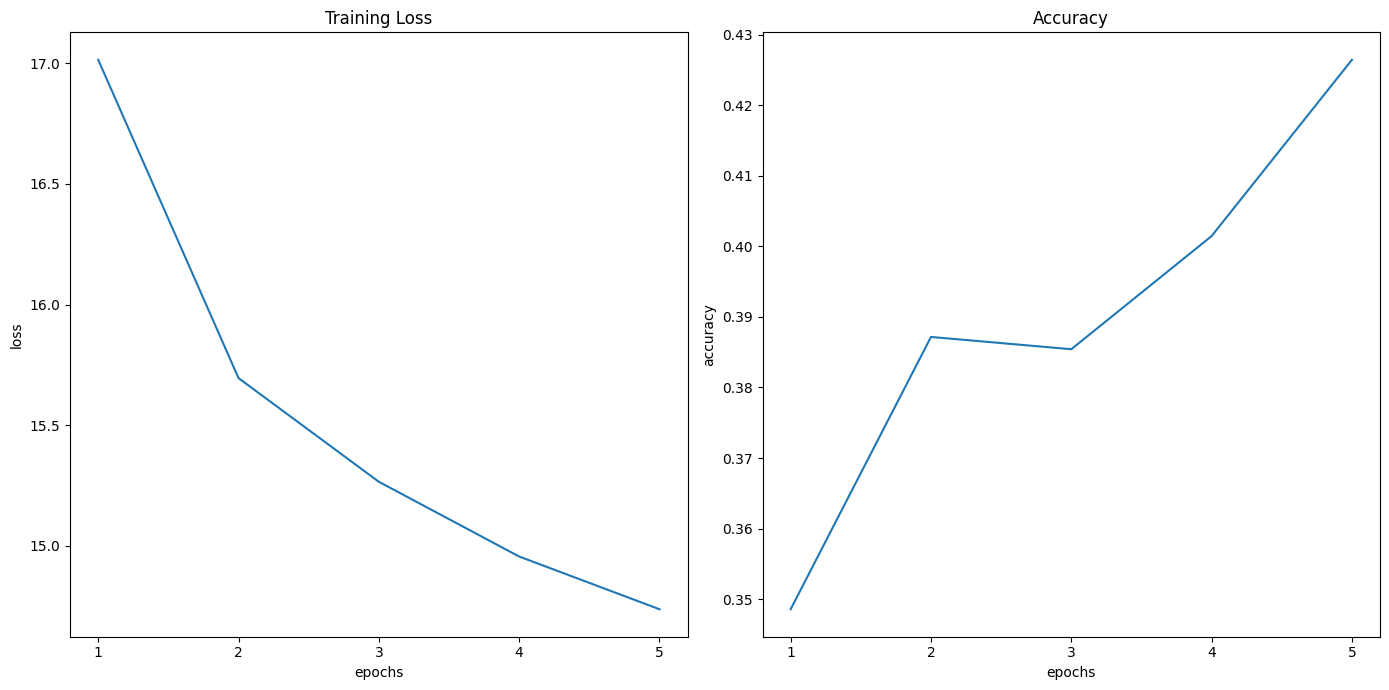

In [27]:
make_plot(epochs, losses=loss, acc=acc)

In [28]:
model_dual.unfreeze()

for name, param in model_dual.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

conv1.weight: requires_grad = True
conv1.bias: requires_grad = True
conv2.weight: requires_grad = True
conv2.bias: requires_grad = True
conv3.weight: requires_grad = True
conv3.bias: requires_grad = True
fc1.weight: requires_grad = True
fc1.bias: requires_grad = True
fc2.weight: requires_grad = True
fc2.bias: requires_grad = True
fc3.weight: requires_grad = True
fc3.bias: requires_grad = True
new_head.0.weight: requires_grad = True
new_head.0.bias: requires_grad = True
new_head.2.weight: requires_grad = True
new_head.2.bias: requires_grad = True


In [29]:
loss, acc, epochs = train_model(model=model_dual, trainloader=trainloader_svhn, 
                                testloader=testloader_svhn, loss_fn=loss_fn, 
                learning_rate = learning_rate, optimizer=optimizer, epoch=5)

/tmp/ipykernel_7664/2341957506.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epoch)):


  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_7664/2341957506.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/18315 [00:00<?, ?it/s]

[1,  2000] loss: 1.486
[1,  4000] loss: 1.335
[1,  6000] loss: 1.247
[1,  8000] loss: 1.148
[1, 10000] loss: 1.113
[1, 12000] loss: 1.044
[1, 14000] loss: 1.006
[1, 16000] loss: 0.955
[1, 18000] loss: 0.925


  0%|          | 0/18315 [00:00<?, ?it/s]

[2,  2000] loss: 0.856
[2,  4000] loss: 0.833
[2,  6000] loss: 0.810
[2,  8000] loss: 0.783
[2, 10000] loss: 0.771
[2, 12000] loss: 0.748
[2, 14000] loss: 0.751
[2, 16000] loss: 0.709
[2, 18000] loss: 0.674


  0%|          | 0/18315 [00:00<?, ?it/s]

[3,  2000] loss: 0.676
[3,  4000] loss: 0.656
[3,  6000] loss: 0.650
[3,  8000] loss: 0.615
[3, 10000] loss: 0.623
[3, 12000] loss: 0.613
[3, 14000] loss: 0.580
[3, 16000] loss: 0.598
[3, 18000] loss: 0.584


  0%|          | 0/18315 [00:00<?, ?it/s]

[4,  2000] loss: 0.546
[4,  4000] loss: 0.572
[4,  6000] loss: 0.549
[4,  8000] loss: 0.540
[4, 10000] loss: 0.555
[4, 12000] loss: 0.515
[4, 14000] loss: 0.519
[4, 16000] loss: 0.519
[4, 18000] loss: 0.505


  0%|          | 0/18315 [00:00<?, ?it/s]

[5,  2000] loss: 0.495
[5,  4000] loss: 0.493
[5,  6000] loss: 0.491
[5,  8000] loss: 0.476
[5, 10000] loss: 0.503
[5, 12000] loss: 0.477
[5, 14000] loss: 0.471
[5, 16000] loss: 0.479
[5, 18000] loss: 0.463


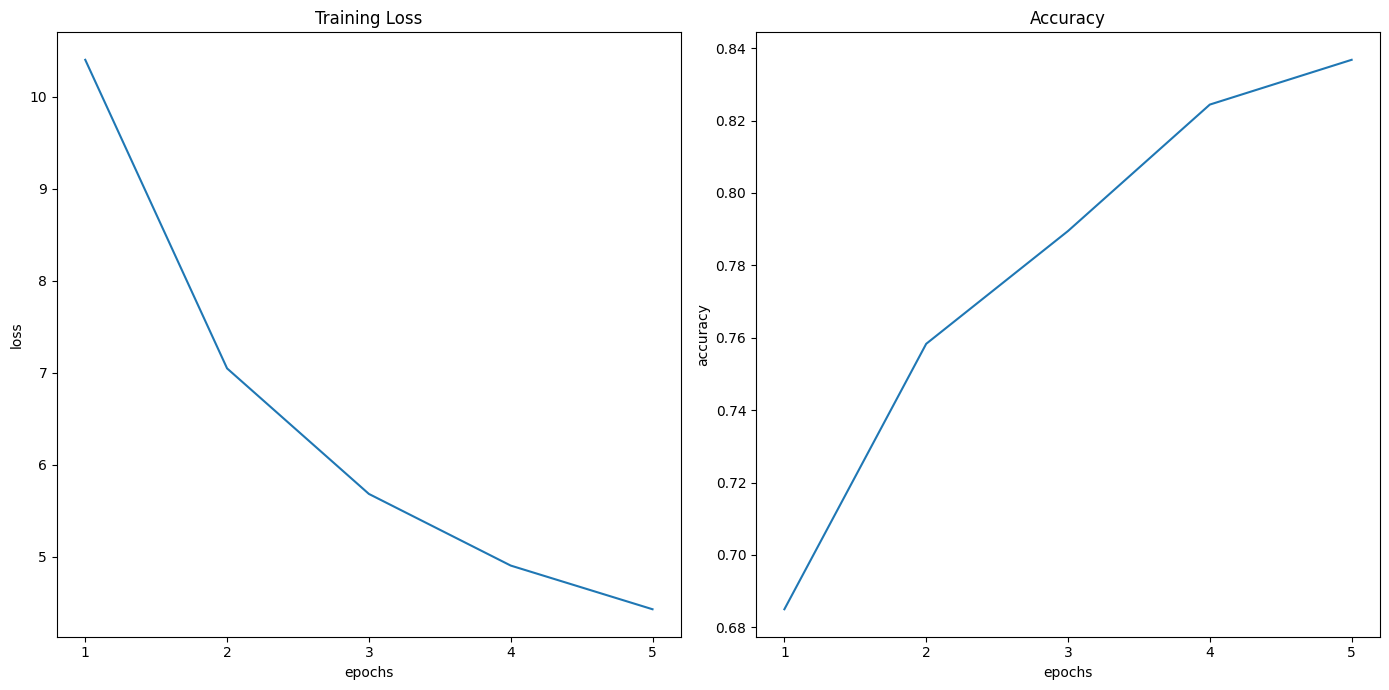

In [30]:
make_plot(epochs, losses=loss, acc=acc)

In [31]:
loss, acc, epochs = train_model(model=model_dual, trainloader=trainloader_mnist, 
                                testloader=testloader_mnist, loss_fn=loss_fn, 
                learning_rate = learning_rate, optimizer=optimizer, epoch=5)

/tmp/ipykernel_7664/2341957506.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epoch)):


  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_7664/2341957506.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.329
[1,  4000] loss: 0.164
[1,  6000] loss: 0.123
[1,  8000] loss: 0.103
[1, 10000] loss: 0.088
[1, 12000] loss: 0.089
[1, 14000] loss: 0.088


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.074
[2,  4000] loss: 0.063
[2,  6000] loss: 0.066
[2,  8000] loss: 0.056
[2, 10000] loss: 0.054
[2, 12000] loss: 0.061
[2, 14000] loss: 0.059


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.054
[3,  4000] loss: 0.052
[3,  6000] loss: 0.048
[3,  8000] loss: 0.048
[3, 10000] loss: 0.045
[3, 12000] loss: 0.040
[3, 14000] loss: 0.044


  0%|          | 0/15000 [00:00<?, ?it/s]

[4,  2000] loss: 0.037
[4,  4000] loss: 0.044
[4,  6000] loss: 0.040
[4,  8000] loss: 0.028
[4, 10000] loss: 0.041
[4, 12000] loss: 0.039
[4, 14000] loss: 0.042


  0%|          | 0/15000 [00:00<?, ?it/s]

[5,  2000] loss: 0.036
[5,  4000] loss: 0.032
[5,  6000] loss: 0.032
[5,  8000] loss: 0.029
[5, 10000] loss: 0.035
[5, 12000] loss: 0.027
[5, 14000] loss: 0.040


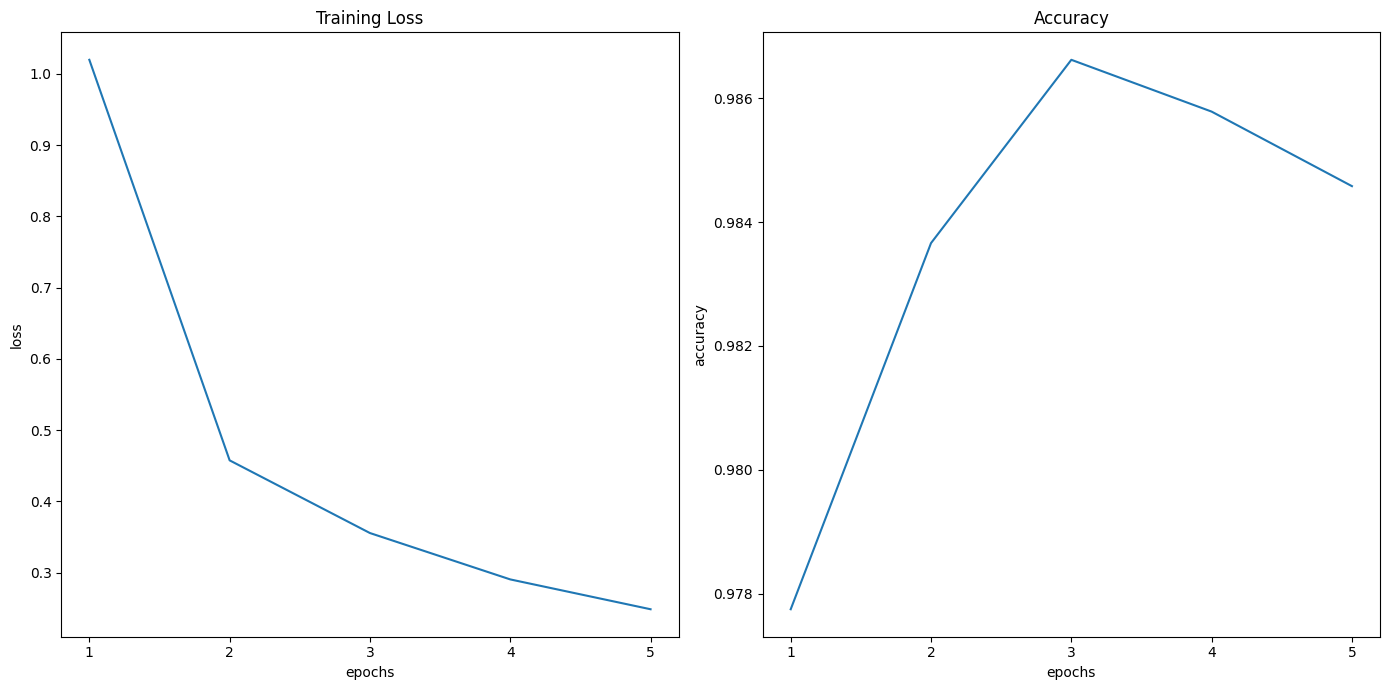

In [32]:
make_plot(epochs, losses=loss, acc=acc)

In [33]:
testloader_svhn =torch.utils.data.DataLoader(testset_svhn, batch_size=64, shuffle=False, num_workers=2)
                                             
all_logits = []
all_labels = []
all_images = []

model_dual.eval()
with torch.no_grad():
    for images, labels in testloader_svhn:
        images = images.to(device)
        logits = model_dual(images)
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
        all_images.append(images.cpu())

all_logits = torch.cat(all_logits, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_images = torch.cat(all_images, dim=0)

num_classes = all_logits.shape[1]
similarity_dict = {}
    
    
for c in range(num_classes):
    mask_c = (all_labels == c)
    images_c = all_images[mask_c]  
    logits_c = all_logits[mask_c]   
               
    for t in range(num_classes):
        max_logit, max_idx = torch.max(logits_c[:, t], dim=0)
            
        most_similar_image = images_c[max_idx]  
        similarity_dict[(c, t)] = most_similar_image
        
similar_images =  similarity_dict  

In [34]:
def plot_similar_images(similarity_dict, class_c, class_t):
    img = similarity_dict[(class_c, class_t)]
    img = img.permute(1, 2, 0).numpy()  # [H, W, C]
    
    plt.imshow(img)
    plt.title(f"Class {class_c} image most similar to class {class_t}")
    plt.axis("off")
    plt.show()

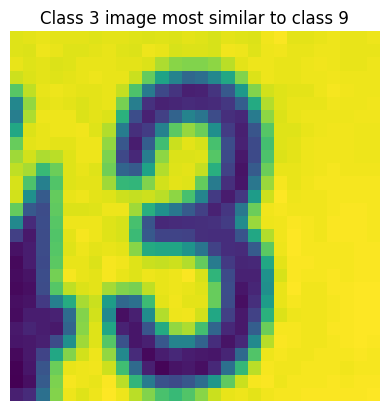

In [35]:
plot_similar_images(similar_images, 3, 9)